In [1]:
import pandas as pd # data analysis
import requests # get url
from bs4 import BeautifulSoup # data scraping
import matplotlib.pyplot as plt # Data visualisation 
import datetime # Check week number
import numpy as np
import datetime as dt #convert date into spesfic format
import re
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression  
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import random
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.model_selection import KFold
from matplotlib import pyplot
from scipy import stats
from sklearn.preprocessing import power_transform
from scipy.stats import boxcox
from sklearn import linear_model

In [ ]:
! pip install requests
! pip install beautifulsoup4
! pip install lxml

In [ ]:
! pip install et_xmlfile

### Scraping all links of the top 2018 movies in the Box Office Mojo

In [ ]:
all_pages=[]
all_url=["https://www.boxofficemojo.com/yearly/chart/?page=%s&view=releasedate&view2=domestic&yr=2018&p=.htm"%(page_number) for page_number in range(1,10)]
final_links=[]

def all_links (url):
    response = requests.get(url)
    page=response.text
    soup=BeautifulSoup(page,"html.parser")
    table=soup.find("table",attrs={"cellpadding":"5"})
    rows=table.find_all("tr")
    if url == "https://www.boxofficemojo.com/yearly/chart/?page=9&view=releasedate&view2=domestic&yr=2018&p=.htm":
        link_list=rows[2:80]
    else:
        link_list=rows[2:101]
    links=[link.a.get("href") for link in link_list ]
    all_links=["https://www.boxofficemojo.com%s"%(elem) for elem in links]
    return all_links

def remove_nested_list(nested_list):
    for one_page in nested_list:
        if type(one_page)==list:
            remove_nested_list(one_page)
        else:
            final_links.append(one_page)

for one_url in all_url:
    results=all_links(one_url)
    all_pages.append(results)
print(len(all_pages))
#print(all_links ("https://www.boxofficemojo.com/yearly/chart/?page=2&view=releasedate&view2=domestic&yr=2019&p=.htm"))
remove_nested_list(all_pages)
print(len(final_links))
#print(final_links)

final_links.remove("https://www.boxofficemojo.com/studio/chart/?studio=fathom.htm")
final_links.remove("https://www.boxofficemojo.com/movies/?id=crime+unishment18.htm")
print(len(final_links))


### Collecting all the features of the top 2018 movies in the Box Office Mojo and building a dataframe

In [ ]:
title=[]
domestic_total_gross=[]
distributor=[]
release_date=[]
runtime=[]
production_budget=[]
MPAA_rating=[]
genre=[]



def convert_minuts(min):
    
    if min == "N/A":
        return "N/A"
    else: 
        numbers = re.findall("\d+", min)
        h=int(numbers[0])
        m=int(numbers[1])
        total = m + (h*60)
        return int(total)



def movies (movies_url):

    movie_url=movies_url
    respon4 = requests.get(movie_url)
    print(respon4.status_code)
    print(i,movie_url)
    all_text=respon4.text
    soup4=BeautifulSoup(all_text,"html.parser")
    table=soup4.find("table",attrs={"cellpadding":"4"})
    
    
    
    title.append(soup4.find('title').text.split("(")[0].strip())
    domestic_total_gross.append(table.font.b.text.replace("$","").replace(",",""))
    distributor.append(soup4.find(text="Distributor: ").findNextSibling().text)
    release_date.append(soup4.find(text="Release Date: ").findNext('a').text)
    
    
    Alltime=soup4.find(text="Runtime: ").findNextSibling().text
    time=convert_minuts(Alltime)
    runtime.append(time)
    
    
    #runtime.append(soup4.find(text="Runtime: ").findNextSibling().text)
    
    
    
    
    
    
    production_budget.append(soup4.find(text="Production Budget: ").findNextSibling().text.replace("$","").replace("million","000000"))
    MPAA_rating.append(soup4.find(text="MPAA Rating: ").findNextSibling().text)
    genre.append(soup4.find(text="Genre: ").findNextSibling().text)
 

for i,individual_url in enumerate(final_links):
    print(i)
    movies(individual_url)

### Create CSV file to store all the information

In [ ]:
df=pd.DataFrame({"Title":title,"Domestic_Total_Gross":domestic_total_gross,
                 "Distributor":distributor,
                "Release_Date":release_date,
                "Runtime":runtime,
                "Production_Budget":production_budget,
                "MPAA_Rating":MPAA_rating,
                "Genre":genre})

In [ ]:
df.shape

In [ ]:
df.to_csv("Movies_Screped_Data2018.csv")

### Data Cleaning

In [2]:
df=pd.read_csv("Movies_Screped_Data2018.csv", index_col=0)

In [3]:
df.shape

(868, 8)

In [681]:
df.columns

Index(['Actual', 'Predicted'], dtype='object')

In [4]:
df.head()

,Title,Domestic_Total_Gross,Distributor,Release_Date,Runtime,Production_Budget,MPAA_Rating,Genre
0,Black Panther,700059566,Buena Vista,"February 16, 2018",140.0,NaN,PG-13,Action / Adventure
1,Avengers: Infinity War,678815482,Buena Vista,"April 27, 2018",156.0,NaN,PG-13,Action / Adventure
2,Incredibles 2,608581744,Buena Vista,"June 15, 2018",118.0,NaN,PG,Animation
3,Jurassic World: Fallen Kingdom,417719760,Universal,"June 22, 2018",128.0,170 000000,PG-13,Action / Adventure
4,Aquaman,335061807,Warner Bros.,"December 21, 2018",139.0,NaN,PG-13,Action / Adventure


In [5]:
df.describe()

,Runtime
count,865.000000
mean,109.993064
std,32.097471
min,14.000000
25%,93.000000
50%,103.000000
75%,118.000000
max,476.000000


In [6]:
df['Release_Date']= pd.to_datetime(df['Release_Date']) 

In [7]:
df['Release_Date'] = df['Release_Date'].apply(lambda x: dt.datetime.strptime(x,'%d%b%Y:%H:%M:%S.%f'),errors = 'coerce')

TypeError: <lambda>() got an unexpected keyword argument 'errors'

In [12]:
df["Month"]=df.Release_Date.dt.strftime('%m')

In [13]:
df["Day"]=df.Release_Date.dt.strftime('%d')

In [14]:
df['day_of_year'] = df['Release_Date'].dt.dayofyear

In [15]:
df.head()

,Title,Domestic_Total_Gross,Distributor,Release_Date,Runtime,Production_Budget,MPAA_Rating,Genre,Day,day_of_year,Month
0,Black Panther,700059566,Buena Vista,2018-02-16,140.0,NaN,PG-13,Action / Adventure,16,47,02
1,Avengers: Infinity War,678815482,Buena Vista,2018-04-27,156.0,NaN,PG-13,Action / Adventure,27,117,04
2,Incredibles 2,608581744,Buena Vista,2018-06-15,118.0,NaN,PG,Animation,15,166,06
3,Jurassic World: Fallen Kingdom,417719760,Universal,2018-06-22,128.0,170 000000,PG-13,Action / Adventure,22,173,06
4,Aquaman,335061807,Warner Bros.,2018-12-21,139.0,NaN,PG-13,Action / Adventure,21,355,12


In [16]:
df.dtypes

Title                           object
Domestic_Total_Gross            object
Distributor                     object
Release_Date            datetime64[ns]
Runtime                        float64
Production_Budget               object
MPAA_Rating                     object
Genre                           object
Day                             object
day_of_year                      int64
Month                           object
dtype: object

In [17]:
df.columns

Index(['Title', 'Domestic_Total_Gross', 'Distributor', 'Release_Date',
       'Runtime', 'Production_Budget', 'MPAA_Rating', 'Genre', 'Day',
       'day_of_year', 'Month'],
      dtype='object')

In [18]:
#df.groupby('MPAA_Rating').nunique()


In [19]:
len(df.Title.unique())

862

In [20]:
df.Genre.value_counts()

Drama                 186
Documentary           159
Animation              68
Comedy                 53
Comedy / Drama         48
Unknown                44
Thriller               33
Musical                24
Action                 24
Horror                 21
Fantasy                18
Action / Adventure     17
Crime Drama            17
Romantic Comedy        15
Drama / Thriller       14
Action Thriller         9
Adventure               9
Horror Thriller         8
Action Comedy           8
Sci-Fi                  7
Action / Crime          7
Crime Thriller          7
Romance                 7
Sci-Fi Action           6
Action Drama            6
Crime Comedy            5
Comedy Thriller         4
Horror Comedy           4
Sci-Fi Thriller         4
War Drama               4
Foreign                 3
Sports Drama            3
Family                  3
Music Drama             2
Family Adventure        2
Sports Action           2
Action Horror           2
Western                 2
Crime       

In [21]:
#df.Distributor.value_counts()[:20]

In [22]:
len(df.MPAA_Rating.unique())

7

In [23]:
#df["Production_Budget"]=df["Production_Budget"].replace("N/A",np.nan)

In [24]:
#df.Production_Budget.isnull().sum()

In [25]:
df['Domestic_Total_Gross'] = df['Domestic_Total_Gross'].apply(lambda x: x.replace("(Estimate)",""))

In [26]:
df = df.astype({"Domestic_Total_Gross": int})

### Show highest movie depending on the Domestic_Total_Gross

In [27]:
df.sort_values('Domestic_Total_Gross', ascending=False).head(5)

,Title,Domestic_Total_Gross,Distributor,Release_Date,Runtime,Production_Budget,MPAA_Rating,Genre,Day,day_of_year,Month
0,Black Panther,700059566,Buena Vista,2018-02-16,140.0,NaN,PG-13,Action / Adventure,16,47,02
1,Avengers: Infinity War,678815482,Buena Vista,2018-04-27,156.0,NaN,PG-13,Action / Adventure,27,117,04
2,Incredibles 2,608581744,Buena Vista,2018-06-15,118.0,NaN,PG,Animation,15,166,06
3,Jurassic World: Fallen Kingdom,417719760,Universal,2018-06-22,128.0,170 000000,PG-13,Action / Adventure,22,173,06
4,Aquaman,335061807,Warner Bros.,2018-12-21,139.0,NaN,PG-13,Action / Adventure,21,355,12


### Dealing with catogrical data

In [28]:
df1=df.copy()

In [29]:
#we can package all of this into a function...

def explode(frame,cat_col,sep=','):
    '''inputs-
    frame: input dataframe
    cat_col: name of the category column
    sep: is the seperator between the catgories
    
    output-
    new dataframe with binary values for category columns
    '''
    df=frame.copy()
    df[cat_col]=df[cat_col].apply(lambda x: x.replace(' ','').split(sep))
    categories=list(set(df[cat_col].sum()))
    df_cat=pd.DataFrame(0,index=df.index,columns=categories)
    for cat in categories:
        df_cat[cat]=df[cat_col].apply(lambda cat_list: int(cat in cat_list))
    return pd.concat([df,df_cat],axis=1)

In [30]:
df1=explode(df,'Genre',sep='/')

In [31]:
df1.shape

(868, 58)

In [32]:
df1.columns

Index(['Title', 'Domestic_Total_Gross', 'Distributor', 'Release_Date',
       'Runtime', 'Production_Budget', 'MPAA_Rating', 'Genre', 'Day',
       'day_of_year', 'Month', 'HorrorComedy', 'Sci-FiFantasy',
       'Sci-FiThriller', 'Adventure', 'Sci-FiComedy', 'Horror', 'ActionDrama',
       'HistoricalDrama', 'MusicDrama', 'Comedy', 'Fantasy', 'Foreign',
       'WarDrama', 'Documentary', 'HorrorThriller', 'Unknown', 'Crime',
       'ActionHorror', 'ActionThriller', 'Sci-FiAction', 'Action', 'Sci-Fi',
       'RomanticThriller', 'FantasyComedy', 'Animation', 'CrimeThriller',
       'CrimeComedy', 'ComedyThriller', 'SportsAction', 'SportsDrama',
       'Concert', 'War', 'Musical', 'CrimeDrama', 'ActionComedy', 'Sports',
       'RomanticComedy', 'Sci-FiHorror', 'FamilyComedy', 'FamilyAdventure',
       'Thriller', 'Western', 'Family', 'Romance', 'Drama', 'Sci-FiAdventure',
       'PeriodDrama'],
      dtype='object')

In [33]:
#df1["Comedy"]=df1["Comedy"]+df1["Sci-FiComedy"]+df1["RomanticComedy"]+df1["FantasyComedy"]+df1["ActionComedy"]+df1["SportsComedy"]+df1["AdventureComedy"]+df1["FamilyComedy"]+df1["CrimeComedy"]

In [34]:
df1['Komedy']=df1[df1.columns[df1.columns.map(lambda x: 'comedy' in x.lower() )]].any(axis=1)

In [35]:
comady_columns_delete=df1.columns[df1.columns.map(lambda x: 'comedy' in x.lower() )]

In [36]:
comady_columns_delete

Index(['HorrorComedy', 'Sci-FiComedy', 'Comedy', 'FantasyComedy',
       'CrimeComedy', 'ComedyThriller', 'ActionComedy', 'RomanticComedy',
       'FamilyComedy'],
      dtype='object')

In [37]:
df1.shape

(868, 59)

In [38]:
#df2.drop(columns=[lambda x: x in comady_columns.values],axis=1)
#df2 = [x.drop(['Ticket','Cabin'], axis=1) for x in comady_columns]

In [39]:
df1[df1.columns[df1.columns.map(lambda x: not('comedy' in x.lower())) ]]

,Title,Domestic_Total_Gross,Distributor,Release_Date,Runtime,Production_Budget,MPAA_Rating,Genre,Day,day_of_year,...,Sci-FiHorror,FamilyAdventure,Thriller,Western,Family,Romance,Drama,Sci-FiAdventure,PeriodDrama,Komedy
0,Black Panther,700059566,Buena Vista,2018-02-16,140.0,NaN,PG-13,"[Action, Adventure]",16,47,...,0,0,0,0,0,0,0,0,0,False
1,Avengers: Infinity War,678815482,Buena Vista,2018-04-27,156.0,NaN,PG-13,"[Action, Adventure]",27,117,...,0,0,0,0,0,0,0,0,0,False
2,Incredibles 2,608581744,Buena Vista,2018-06-15,118.0,NaN,PG,[Animation],15,166,...,0,0,0,0,0,0,0,0,0,False
3,Jurassic World: Fallen Kingdom,417719760,Universal,2018-06-22,128.0,170 000000,PG-13,"[Action, Adventure]",22,173,...,0,0,0,0,0,0,0,0,0,False
4,Aquaman,335061807,Warner Bros.,2018-12-21,139.0,NaN,PG-13,"[Action, Adventure]",21,355,...,0,0,0,0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
863,Gangsterdam,954,Distrib Films,2018-09-19,100.0,NaN,Unrated,[ComedyThriller],19,262,...,0,0,0,0,0,0,0,0,0,True
864,The Breadwinner,834,Gathr Films,2018-04-13,94.0,NaN,PG-13,[Animation],13,103,...,0,0,0,0,0,0,0,0,0,False
865,TVTV: Video Revolutionaries,812,First Run,2018-10-19,82.0,NaN,Unrated,[Documentary],19,292,...,0,0,0,0,0,0,0,0,0,False
866,Higher Power,528,Magnolia,2018-05-11,93.0,NaN,R,[Action],11,131,...,0,0,0,0,0,0,0,0,0,False


In [40]:
#np.cos(2*np.pi*150/364),np.sin(2*np.pi*150/364)

In [41]:
df1.Komedy.value_counts()

False    728
True     140
Name: Komedy, dtype: int64

In [42]:
df1=df1.drop(columns=['CrimeComedy', 'Sci-FiComedy', 'FantasyComedy', 'ComedyThriller',
       'Comedy', 'ActionComedy', 'RomanticComedy', 'FamilyComedy',
       'HorrorComedy'])

In [43]:
df1=df1.drop(columns=["Genre"])

In [44]:
df1.shape

(868, 49)

In [45]:
#df1["Drama"]=df1["Drama"]+df1["SportsDrama"]+df1["WarDrama"]+df1["ActionDrama"]+df1["CrimeDrama"]+df1["HistoricalDrama"]

In [46]:
df1['Dorama']=df1[df1.columns[df1.columns.map(lambda x: 'drama' in x.lower() )]].any(axis=1)

In [47]:
df1.Dorama.value_counts()

False    586
True     282
Name: Dorama, dtype: int64

In [48]:
Dorama_columns_delete=df1.columns[df1.columns.map(lambda x: 'drama' in x.lower() )]

In [49]:
Dorama_columns_delete

Index(['ActionDrama', 'HistoricalDrama', 'MusicDrama', 'WarDrama',
       'SportsDrama', 'CrimeDrama', 'Drama', 'PeriodDrama'],
      dtype='object')

In [50]:
df1=df1.drop(columns=['PeriodDrama', 'CrimeDrama', 'ActionDrama', 'Drama', 'HistoricalDrama',
       'SportsDrama', 'MusicDrama', 'WarDrama'])

In [51]:
df1.shape

(868, 42)

In [52]:
df1['DoKumentary']=df1[df1.columns[df1.columns.map(lambda x: 'documentary' in x.lower() )]].any(axis=1)

In [53]:
df1.DoKumentary.value_counts()

False    709
True     159
Name: DoKumentary, dtype: int64

In [54]:
DoKumentary_columns_delete=df1.columns[df1.columns.map(lambda x: 'documentary' in x.lower() )]

In [55]:
DoKumentary_columns_delete

Index(['Documentary'], dtype='object')

In [56]:
df1['Anoimation']=df1[df1.columns[df1.columns.map(lambda x: 'animation' in x.lower() )]].any(axis=1)

In [57]:
Anoimation_columns_delete=df1.columns[df1.columns.map(lambda x: 'animation' in x.lower() )]

In [58]:
df1.Anoimation.value_counts()

False    800
True      68
Name: Anoimation, dtype: int64

In [59]:
df1=df1.drop(columns=["Animation","Documentary"])

In [60]:
df1.shape

(868, 42)

In [61]:
df1.columns

Index(['Title', 'Domestic_Total_Gross', 'Distributor', 'Release_Date',
       'Runtime', 'Production_Budget', 'MPAA_Rating', 'Day', 'day_of_year',
       'Month', 'Sci-FiFantasy', 'Sci-FiThriller', 'Adventure', 'Horror',
       'Fantasy', 'Foreign', 'HorrorThriller', 'Unknown', 'Crime',
       'ActionHorror', 'ActionThriller', 'Sci-FiAction', 'Action', 'Sci-Fi',
       'RomanticThriller', 'CrimeThriller', 'SportsAction', 'Concert', 'War',
       'Musical', 'Sports', 'Sci-FiHorror', 'FamilyAdventure', 'Thriller',
       'Western', 'Family', 'Romance', 'Sci-FiAdventure', 'Komedy', 'Dorama',
       'DoKumentary', 'Anoimation'],
      dtype='object')

In [62]:
df1["Othors"]=df1[df1.columns[df1.columns.map(lambda x: x.lower() not in ['title', 'domestic_total_gross','distributor', 'release_date','runtime', 'production_budget', 'mpaa_rating', 'month', 'day','day_of_year','komedy', 'dorama','dokumentary', 'anoimation']  ) ]].any(axis=1)

In [63]:
df1['Othors'].value_counts()

False    587
True     281
Name: Othors, dtype: int64

In [64]:
df1.shape

(868, 43)

In [65]:
df1.columns

Index(['Title', 'Domestic_Total_Gross', 'Distributor', 'Release_Date',
       'Runtime', 'Production_Budget', 'MPAA_Rating', 'Day', 'day_of_year',
       'Month', 'Sci-FiFantasy', 'Sci-FiThriller', 'Adventure', 'Horror',
       'Fantasy', 'Foreign', 'HorrorThriller', 'Unknown', 'Crime',
       'ActionHorror', 'ActionThriller', 'Sci-FiAction', 'Action', 'Sci-Fi',
       'RomanticThriller', 'CrimeThriller', 'SportsAction', 'Concert', 'War',
       'Musical', 'Sports', 'Sci-FiHorror', 'FamilyAdventure', 'Thriller',
       'Western', 'Family', 'Romance', 'Sci-FiAdventure', 'Komedy', 'Dorama',
       'DoKumentary', 'Anoimation', 'Othors'],
      dtype='object')

In [66]:
df1=df1.drop(columns=['Sports', 'Family', 'Sci-FiAction', 'Action', 'Foreign','FamilyAdventure', 'War', 'HorrorThriller', 'Western', 'SportsAction','Horror', 'ActionThriller', 'Sci-Fi', 'Crime', 'Adventure','Sci-FiThriller', 'Fantasy', 'Romance', 'Sci-FiHorror', 'Sci-FiFantasy','CrimeThriller', 'ActionHorror', 'Sci-FiAdventure', 'Thriller','Musical', 'Unknown', 'Concert', 'RomanticThriller'])

In [67]:
df1.shape

(868, 15)

In [68]:
df1.columns

Index(['Title', 'Domestic_Total_Gross', 'Distributor', 'Release_Date',
       'Runtime', 'Production_Budget', 'MPAA_Rating', 'Day', 'day_of_year',
       'Month', 'Komedy', 'Dorama', 'DoKumentary', 'Anoimation', 'Othors'],
      dtype='object')

In [69]:
df2=df1.copy()

In [70]:
df2.shape

(868, 15)

In [71]:
df2.columns

Index(['Title', 'Domestic_Total_Gross', 'Distributor', 'Release_Date',
       'Runtime', 'Production_Budget', 'MPAA_Rating', 'Day', 'day_of_year',
       'Month', 'Komedy', 'Dorama', 'DoKumentary', 'Anoimation', 'Othors'],
      dtype='object')

In [72]:
df2 = pd.get_dummies(df2, columns=['Komedy','Othors','Anoimation','DoKumentary','Dorama'],drop_first=True)

In [73]:
df2.shape

(868, 15)

In [74]:
df2['MPAA_Rating'] = df2['MPAA_Rating'].astype('category')
cat_columns = df2.select_dtypes(['category']).columns
df2[cat_columns] = df2[cat_columns].apply(lambda x: x.cat.codes)

In [75]:
df2.Runtime.mean()

109.99306358381503

In [76]:
df2["Runtime"].fillna(109, inplace = True) 

In [77]:
df2.isna().sum()

Title                     0
Domestic_Total_Gross      0
Distributor               0
Release_Date              0
Runtime                   0
Production_Budget       772
MPAA_Rating               0
Day                       0
day_of_year               0
Month                     0
Komedy_True               0
Othors_True               0
Anoimation_True           0
DoKumentary_True          0
Dorama_True               0
dtype: int64

In [78]:
df2.columns

Index(['Title', 'Domestic_Total_Gross', 'Distributor', 'Release_Date',
       'Runtime', 'Production_Budget', 'MPAA_Rating', 'Day', 'day_of_year',
       'Month', 'Komedy_True', 'Othors_True', 'Anoimation_True',
       'DoKumentary_True', 'Dorama_True'],
      dtype='object')

In [79]:
df3=df2.copy()

In [80]:
df3=df3.drop(columns=["Title","Distributor","Production_Budget"])

In [81]:
df3.columns

Index(['Domestic_Total_Gross', 'Release_Date', 'Runtime', 'MPAA_Rating', 'Day',
       'day_of_year', 'Month', 'Komedy_True', 'Othors_True', 'Anoimation_True',
       'DoKumentary_True', 'Dorama_True'],
      dtype='object')

In [193]:
df3

,Domestic_Total_Gross,Release_Date,Runtime,MPAA_Rating,Day,day_of_year,Month,Komedy_True,Othors_True,Anoimation_True,DoKumentary_True,Dorama_True
538,11.378251,2018-10-19,98.0,6,19,292,10,0,0,0,1,0
577,11.090172,2018-08-17,79.0,6,17,229,08,0,0,0,1,0
111,16.611331,2018-01-19,104.0,2,19,19,01,0,1,0,0,0
410,12.279764,2018-01-14,126.0,6,14,14,01,0,1,0,0,0
844,7.769379,2018-08-10,92.0,6,10,222,08,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
66,17.601277,2018-06-08,126.0,4,08,159,06,0,1,0,0,0
287,13.416350,2018-08-10,134.0,6,10,222,08,1,0,0,0,1
315,13.122565,2018-09-28,95.0,4,28,271,09,0,0,0,0,1
376,12.528862,2018-09-14,90.0,2,14,257,09,0,0,0,1,0


In [214]:
df3=shuffle(df3)

In [ ]:
### 

In [405]:
df5=df3.copy()

In [406]:
df5.columns

Index(['Domestic_Total_Gross', 'Release_Date', 'Runtime', 'MPAA_Rating', 'Day',
       'day_of_year', 'Month', 'Komedy_True', 'Othors_True', 'Anoimation_True',
       'DoKumentary_True', 'Dorama_True'],
      dtype='object')

### Power Transformer (No good results especially with binary data)
#### BoxCox is method to transform data especially with 1D data

In [620]:
df5['Runtime']= boxcox(df5['Runtime'])

pyplot.figure(1)

# histogram
pyplot.subplot(212)
pyplot.hist(df5['Runtime'])
pyplot.show()

ValueError: Data must be positive.

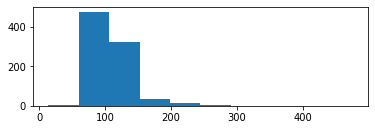

In [615]:
pyplot.figure(1)
pyplot.subplot(212)
pyplot.hist(df3['Runtime'])
pyplot.show()

### Split data into training , validation , and testing

In [495]:
x=df3.loc[:,['Runtime', 'MPAA_Rating', 'Day', 'day_of_year',
       'Month', 'Komedy_True','Othors_True', 'Anoimation_True',
       'DoKumentary_True', 'Dorama_True']]
y=df3.loc[:,"Domestic_Total_Gross"]

In [496]:
X_train_val, X_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [497]:
X_Y_train=X_train.copy()
X_Y_train[y_train.name]=y_train
X_Y_train.isna().sum()
X_Y_train.shape

(520, 11)

In [498]:
X_Y_val=X_val.copy()
X_Y_val[y_val.name]=y_val
X_Y_val.isna().sum()
X_Y_val.shape

(174, 11)

In [499]:
sample=pd.concat([X_Y_train,X_Y_val],ignore_index=True)
sample.isna().sum()

sample.Month=sample["Month"].astype(float)
sample.Day=sample.Day.astype(float)

sample.dtypes

Runtime                 float64
MPAA_Rating                int8
Day                     float64
day_of_year               int64
Month                   float64
Komedy_True               uint8
Othors_True               uint8
Anoimation_True           uint8
DoKumentary_True          uint8
Dorama_True               uint8
Domestic_Total_Gross    float64
dtype: object

### Exploratory Data Analysis (EDA)

In [500]:
df3.shape

(868, 12)

In [501]:
df3.rename(columns=lambda x: x.strip())

,Domestic_Total_Gross,Release_Date,Runtime,MPAA_Rating,Day,day_of_year,Month,Komedy_True,Othors_True,Anoimation_True,DoKumentary_True,Dorama_True
815,8.452121,2018-07-13,100.0,6,13,194,07,0,0,0,1,0
396,12.368315,2018-03-08,210.0,6,08,67,03,0,1,0,0,0
95,17.019179,2018-12-25,120.0,3,25,359,12,0,0,0,0,1
120,16.326803,2018-06-29,96.0,3,29,180,06,0,0,0,1,0
687,10.001567,2018-03-23,113.0,1,23,82,03,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
306,13.209636,2018-11-30,92.0,4,30,334,11,0,1,0,0,0
802,8.615771,2018-02-23,77.0,6,23,54,02,1,0,0,0,0
664,10.240424,2018-04-13,106.0,6,13,103,04,0,0,0,0,1
145,15.626390,2018-03-09,103.0,3,09,68,03,0,1,0,0,0


In [502]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 868 entries, 815 to 845
Data columns (total 12 columns):
Domestic_Total_Gross    868 non-null float64
Release_Date            868 non-null datetime64[ns]
Runtime                 868 non-null float64
MPAA_Rating             868 non-null int8
Day                     868 non-null object
day_of_year             868 non-null int64
Month                   868 non-null object
Komedy_True             868 non-null uint8
Othors_True             868 non-null uint8
Anoimation_True         868 non-null uint8
DoKumentary_True        868 non-null uint8
Dorama_True             868 non-null uint8
dtypes: datetime64[ns](1), float64(2), int64(1), int8(1), object(2), uint8(5)
memory usage: 52.6+ KB


In [503]:
df3.isna().sum()

Domestic_Total_Gross    0
Release_Date            0
Runtime                 0
MPAA_Rating             0
Day                     0
day_of_year             0
Month                   0
Komedy_True             0
Othors_True             0
Anoimation_True         0
DoKumentary_True        0
Dorama_True             0
dtype: int64

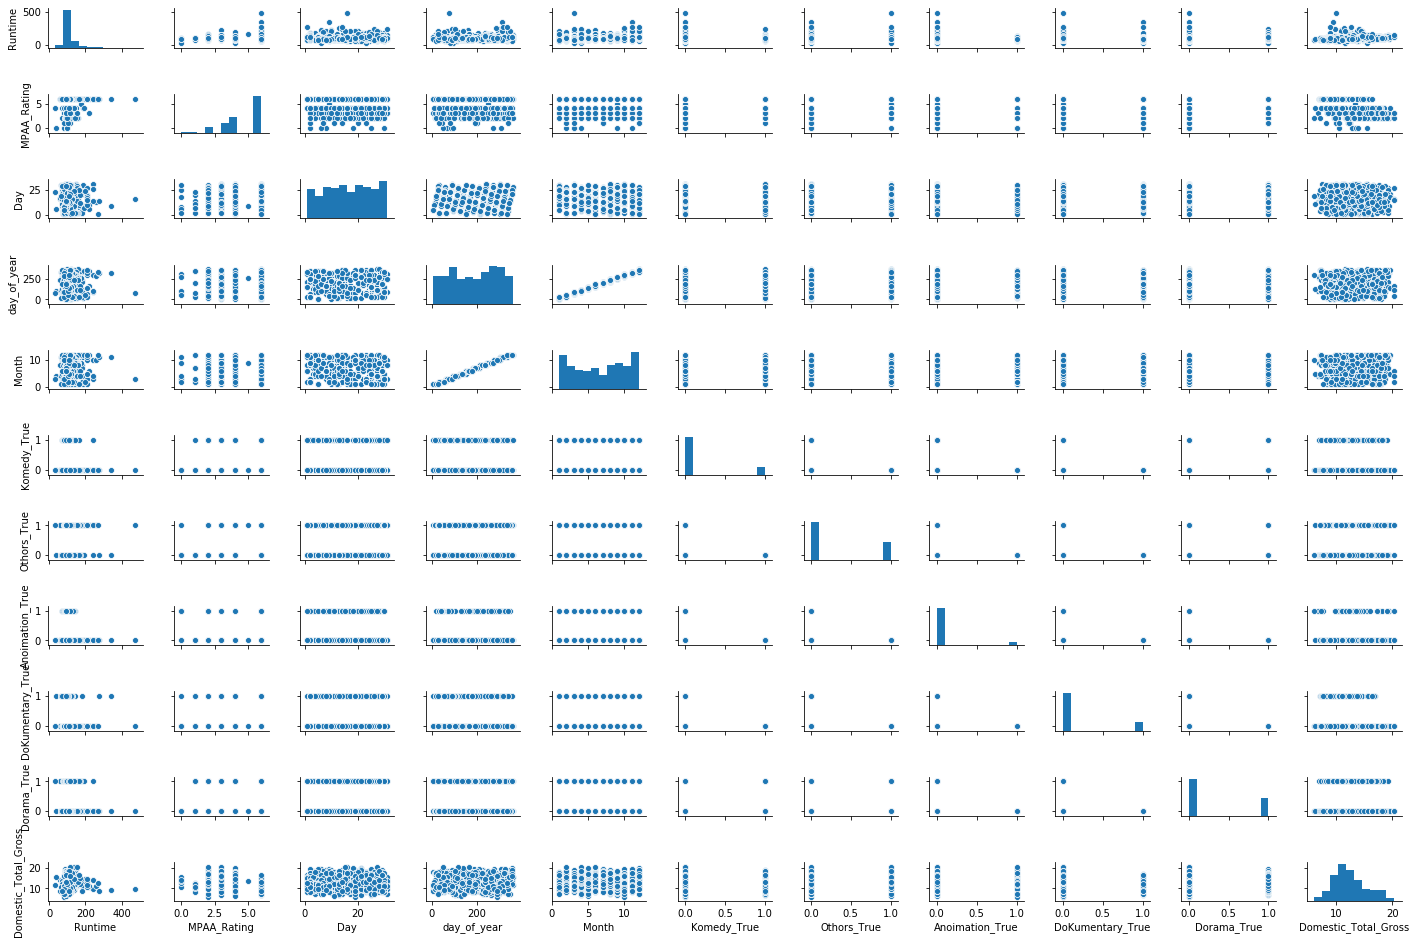

In [679]:
sns.pairplot(sample, height=1.2, aspect=1.5)
save_results_to = '/Users/Mony/Downloads/'
plt.savefig(save_results_to+"Pair Plot", format='png', quality=95)

In [505]:
sample.corr()

,Runtime,MPAA_Rating,Day,day_of_year,Month,Komedy_True,Othors_True,Anoimation_True,DoKumentary_True,Dorama_True,Domestic_Total_Gross
Runtime,1.000000,0.068514,-0.000283,0.084720,0.084813,-0.099616,0.293064,-0.118117,-0.192651,-0.034170,0.138776
MPAA_Rating,0.068514,1.000000,0.020642,-0.063725,-0.065722,0.012281,-0.060265,-0.191493,0.216204,0.008329,-0.482530
Day,-0.000283,0.020642,1.000000,0.082111,-0.002502,0.052066,-0.033060,-0.005832,-0.002507,0.027095,0.031429
day_of_year,0.084720,-0.063725,0.082111,1.000000,0.996392,-0.071860,-0.018512,0.019813,0.000118,0.053646,0.068106
Month,0.084813,-0.065722,-0.002502,0.996392,1.000000,-0.076203,-0.015807,0.020089,0.000508,0.051658,0.065558
Komedy_True,-0.099616,0.012281,0.052066,-0.071860,-0.076203,1.000000,-0.309382,-0.134095,-0.211107,0.022482,-0.019277
Othors_True,0.293064,-0.060265,-0.033060,-0.018512,-0.015807,-0.309382,1.000000,-0.202511,-0.318815,-0.413976,0.237265
Anoimation_True,-0.118117,-0.191493,-0.005832,0.019813,0.020089,-0.134095,-0.202511,1.000000,-0.138184,-0.205205,0.030746
DoKumentary_True,-0.192651,0.216204,-0.002507,0.000118,0.000508,-0.211107,-0.318815,-0.138184,1.000000,-0.323056,-0.263563
Dorama_True,-0.034170,0.008329,0.027095,0.053646,0.051658,0.022482,-0.413976,-0.205205,-0.323056,1.000000,-0.084358


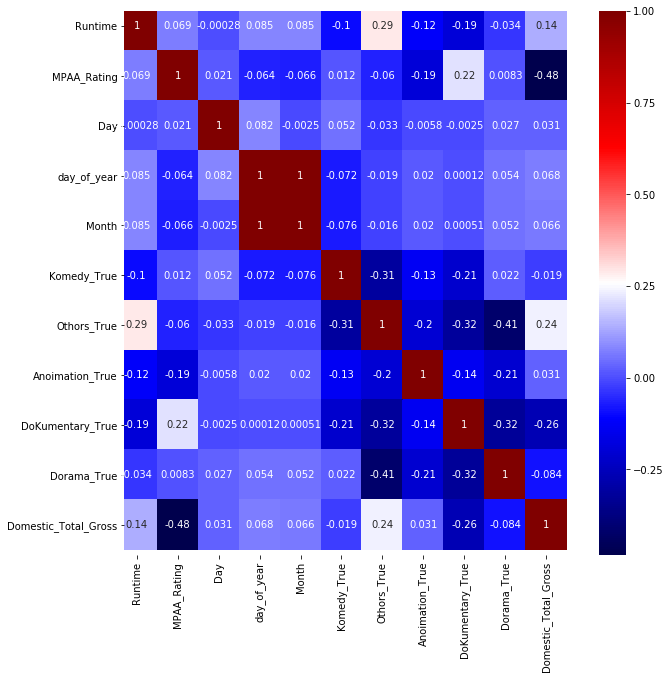

In [678]:
plt.figure(figsize=(10, 10))
sns.heatmap(sample.corr(),cmap="seismic",annot=True)
plt.xlim(0.2,11.1)
plt.ylim(11.1,0.2)
save_results_to = '/Users/Mony/Downloads/'
plt.savefig(save_results_to+"Heat Map", format='png', quality=95)

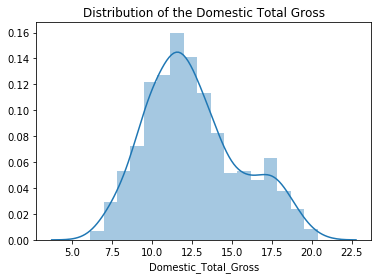

In [682]:
sns.distplot(sample["Domestic_Total_Gross"], kde=True)
plt.title("Distribution of the Domestic Total Gross")
save_results_to = '/Users/Mony/Downloads/'
plt.savefig(save_results_to+"Domestic_Total_Gross", format='png', quality=95)

In [684]:
df3.Domestic_Total_Gross

815     8.452121
396    12.368315
95     17.019179
120    16.326803
687    10.001567
         ...    
306    13.209636
802     8.615771
664    10.240424
145    15.626390
845     7.724447
Name: Domestic_Total_Gross, Length: 868, dtype: float64

In [625]:
df4=df3.copy()

### Building a Baseline

In [509]:

df4=df4.drop(columns=['Release_Date'])

In [510]:
df4.columns

Index(['Domestic_Total_Gross', 'Runtime', 'MPAA_Rating', 'Day', 'day_of_year',
       'Month', 'Komedy_True', 'Othors_True', 'Anoimation_True',
       'DoKumentary_True', 'Dorama_True'],
      dtype='object')

In [511]:
X_train=X_train.astype(float)
y_train=y_train.astype(float)

In [530]:
X_train = sm.add_constant(X_train)
movie_model = sm.OLS(y_train, X_train, data=df4)

results = movie_model.fit()


results.summary()

/Users/Mony/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Domestic_Total_Gross   R-squared:                       0.358
Model:                              OLS   Adj. R-squared:                  0.345
Method:                   Least Squares   F-statistic:                     28.34
Date:                  Wed, 18 Sep 2019   Prob (F-statistic):           3.63e-43
Time:                          10:16:18   Log-Likelihood:                -1191.4
No. Observations:                   520   AIC:                             2405.
Df Residuals:                       509   BIC:                             2452.
Df Model:                            10                                         
Covariance Type:              nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               16.1525      5.006      3.227      0.001       6.318      25.987
Runtime              0.0125      0.004      3.049      0.002       0.004       0.021
MPAA_Rating         -0.9863      0.073    -13.591      0.000      -1.129      -0.844
Day                  0.0372      0.159      0.234      0.815      -0.275       0.349
day_of_year         -0.0236      0.159     -0.149      0.882      -0.335       0.288
Month                0.7491      4.826      0.155      0.877      -8.733      10.231
Komedy_True         -0.9823      0.433     -2.267      0.024      -1.834      -0.131
Othors_True         -0.5187      0.503     -1.032      0.303      -1.506       0.469
Anoimation_True     -2.1299      0.627     -3.395      0.001      -3.362      -0.897
DoKumentary_True    -2.2678      0.566     -4.007      0.000      -3.380      -1.156
Dorama_True         -1.6523      0.443     -3.728      0.000      -2.523      -0.782
==============================================================================
Omnibus:                        6.328   Durbin-Watson:                   2.077
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                6.439
Skew:                          -0.257   Prob(JB):                       0.0400
Kurtosis:                       2.820   Cond. No.                     1.55e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [676]:
X_train=X_train.astype(float)
y_train=y_train.astype(float)

X_train_drop=X_train.copy()

X_train_drop.drop(columns=["day_of_year","Day","Month","Othors_True"],inplace= True)


movie_model1 = sm.OLS(y_train, X_train_drop, data=df4)

results1 = movie_model1.fit()


results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Domestic_Total_Gross   R-squared:                       0.354
Model:                              OLS   Adj. R-squared:                  0.346
Method:                   Least Squares   F-statistic:                     46.77
Date:                  Wed, 18 Sep 2019   Prob (F-statistic):           1.05e-45
Time:                          16:51:26   Log-Likelihood:                -1193.1
No. Observations:                   520   AIC:                             2400.
Df Residuals:                       513   BIC:                             2430.
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               16.7923      0.589     28.525      0.000      15.636      17.949
Runtime              0.0132      0.004      3.247      0.001       0.005       0.021
MPAA_Rating         -0.9915      0.072    -13.709      0.000      -1.134      -0.849
Komedy_True         -0.6542      0.291     -2.251      0.025      -1.225      -0.083
Anoimation_True     -1.6305      0.436     -3.740      0.000      -2.487      -0.774
DoKumentary_True    -1.7847      0.340     -5.255      0.000      -2.452      -1.118
Dorama_True         -1.2415      0.248     -5.007      0.000      -1.729      -0.754
==============================================================================
Omnibus:                        6.313   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.043   Jarque-Bera (JB):                6.408
Skew:                          -0.255   Prob(JB):                       0.0406
Kurtosis:                       2.810   Cond. No.                         695.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

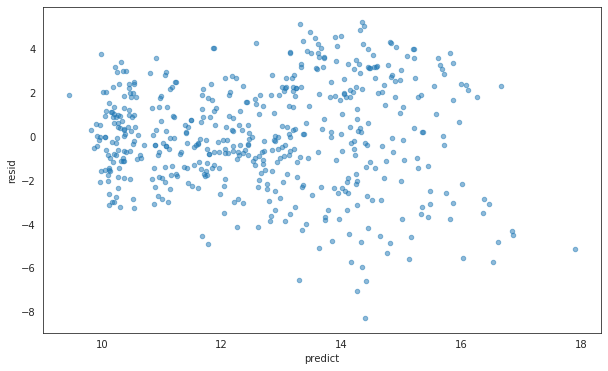

In [680]:
# create residual plot
df4['predict']=results.predict(X_train)
df4['resid']= y_train-df4.predict
with sns.axes_style('white'):
    plot = df4.plot(
        kind='scatter', x='predict', y='resid', alpha=0.5, figsize=(10,6))
save_results_to = '/Users/Mony/Downloads/'
plt.savefig(save_results_to+"Domestic_Total_Gross", format='png', quality=95)

In [631]:
df4.predict

815    10.370944
396    13.302291
95           NaN
120          NaN
687          NaN
         ...    
306          NaN
802          NaN
664    10.958202
145          NaN
845          NaN
Name: predict, Length: 868, dtype: float64

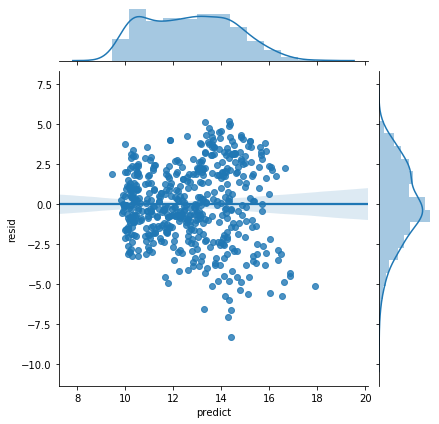

In [633]:
sns.jointplot(kind="regplot", x='predict', y='resid', data=df4)

In [514]:
# sns.distplot(df3["Domestic_Total_Gross"], kde=True)
# plt.title("Distribution of Domestic_Total_Gross")
# #plt.savefig("Domestic_Total_Gross", format='svg')

In [560]:
sample.columns

Index(['Runtime', 'MPAA_Rating', 'Day', 'day_of_year', 'Month', 'Komedy_True',
       'Othors_True', 'Anoimation_True', 'DoKumentary_True', 'Dorama_True',
       'Domestic_Total_Gross'],
      dtype='object')

In [695]:
X_train=X_train.drop(columns=["const"])

In [723]:
def linear_CV():
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    #X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    scores = cross_val_score(lr_model, X_train_val, y_train_val, cv=5)
    #lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    #val_score = lr_model.score(X_val, y_val)
    
    # report results
    #print('Validation R^2 score is:',val_score)

    #for feature, coef in zip(X_train.columns, lr_model.coef_):
     #   print(feature, ':', f'{coef:.2f}') 
    print(scores.mean()) 
    lr_model.fit(X_test, y_test)
    test_score = lr_model.score(X_test, y_test)
    print('test R^2 score is:',test_score)

In [724]:
linear_CV()

0.28257985845170264
test R^2 score is: 0.30383835662638836


### Regularization

In [732]:
def regularization(X_train_val1, y_train_val1,X_test1,y_test1):

    reg_elastic_net_CV = linear_model.ElasticNetCV(eps = None, n_alphas = None,max_iter=10000, 
                                                   alphas=10**(np.linspace(-2,3,30)), 
                                                   l1_ratio = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0],
                                                   cv=5)
    reg_elastic_net_CV.fit(X_train_val1, y_train_val1)
    score = cross_val_score(reg_elastic_net_CV, X_train_val1, y_train_val1, cv=5).mean()
    print('Validation R^2 score is:',score)

    hps = [reg_elastic_net_CV.alpha_, reg_elastic_net_CV.l1_ratio_]

    
    #print(list(zip(X_train_val1.columns, reg_elastic_net_CV.coef_)))
    test_model = linear_model.ElasticNet(alpha=hps[0], l1_ratio=hps[1])
    test_model.fit(X_test1,y_test1)

   
    
    test_score = test_model.score(X_test1,y_test1)
    print('Test R^2 score is:', test_score)
    
    
    predecate= reg_elastic_net_CV.predict(X_test1)
    print("\nSample of Actual vs Predicted data")
    df=pd.DataFrame({"Actual":y_test1, "predicted":predecate})
    print(df.head())
    
    
    for feature, coef in list(zip(X_train_val1.columns, reg_elastic_net_CV.coef_)):
         print(feature, ':', f'{coef:.2f}') 
    
    
 

### Model 1 (Baseline with Regularization)

In [733]:
regularization(X_train_val, y_train_val,X_test,y_test)

Validation R^2 score is: 0.2812546841198662
Test R^2 score is: 0.2985945432012339

Sample of Actual vs Predicted data
        Actual  predicted
73   17.524838  14.179007
460  11.931524  12.264915
841   7.895063  10.508818
298  13.275230  13.351745
673  10.165929  11.213372
Runtime : 0.01
MPAA_Rating : -0.88
Day : 0.01
day_of_year : 0.00
Month : -0.00
Komedy_True : -0.27
Othors_True : 0.24
Anoimation_True : -0.90
DoKumentary_True : -1.40
Dorama_True : -0.84


/Users/Mony/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 465.31137471605047, tolerance: 0.14583996722228962
  positive)


In [734]:
final=LinearRegression()
final.coef_=np.array([ 9.32089274e-03, -8.75220885e-01,  1.48918717e-02,  9.66217552e-04,
        -0.00000000e+00, -2.72625965e-01,  2.44174754e-01, -9.02083570e-01,
        -1.39950649e+00, -8.37463147e-01])
final.intercept_=15.750581659139684

In [735]:
final.score(X_test,y_test)

0.2463184574498224

### Model 2

In [736]:
x2=X_train_val.copy()
x2_test=X_test.copy()

x2.drop(columns=["day_of_year","Day","Month","Othors_True"])
x2_test.drop(columns=["day_of_year","Day","Month","Othors_True"])

regularization(x2, y_train_val,x2_test,y_test)






Validation R^2 score is: 0.2812546841198662
Test R^2 score is: 0.2985945432012339

Sample of Actual vs Predicted data
        Actual  predicted
73   17.524838  14.179007
460  11.931524  12.264915
841   7.895063  10.508818
298  13.275230  13.351745
673  10.165929  11.213372
Runtime : 0.01
MPAA_Rating : -0.88
Day : 0.01
day_of_year : 0.00
Month : -0.00
Komedy_True : -0.27
Othors_True : 0.24
Anoimation_True : -0.90
DoKumentary_True : -1.40
Dorama_True : -0.84


/Users/Mony/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 465.31137471605047, tolerance: 0.14583996722228962
  positive)


### Model 3

### Model 4 